## This file is for loading the dataset, and constructing underlying models

### <u>Imports<u>

In [1]:
import pandas as pd
import numpy as np

# for histogram plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### <u>Loading the Datasets<u>

In [2]:
Dataset_SOn = pd.read_csv('C:/Users/pymnb/Downloads/WAG Case/18/Datasets/Dataset_SOn1.csv', header = None)
Dataset_Pn  = pd.read_csv('C:/Users/pymnb/Downloads/WAG Case/18/Datasets/Dataset_Pn1.csv', header = None)

#Dataset_SOn_150 = pd.read_csv('C:/Users/pymnb/Downloads/WAG Case/15/Datasets/Dataset_SOn_150.csv', header = None)
#Dataset_SOn_250 = pd.read_csv('C:/Users/pymnb/Downloads/WAG Case/15/Datasets/Dataset_SOn_250.csv', header = None)
#Dataset_Pn_150 = pd.read_csv('C:/Users/pymnb/Downloads/WAG Case/15/Datasets/Dataset_Pn_150.csv', header = None)
#Dataset_Pn_250 = pd.read_csv('C:/Users/pymnb/Downloads/WAG Case/15/Datasets/Dataset_Pn_250.csv', header = None)

## Histogram of outputs

(0.0, 150000.0)

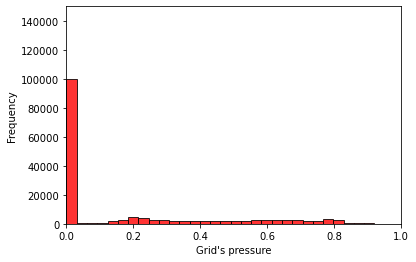

In [3]:
fig, ax = plt.subplots()

Histo_SO = np.array(Dataset_SOn)[:,39:40]
Histo_P  = np.array(Dataset_Pn)[:,39:40]

#                                                     bar opacity  the bigger, the more splits on x axis
plt.hist(Histo_SO, color = 'red', edgecolor = 'black', alpha=0.8,  bins = 30 )
plt.xlabel("Grid's pressure")
plt.ylabel("Frequency")
plt.xlim([0, 1])   #change it depend on the ranges
plt.ylim([0, 150000])    #change it depend on the ranges

# this line is to show the y axis in K
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '%.0fk' % (y * 1e-3)))   
#plt.savefig("Histogram-P.jpg")

## CNN model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 90)            990       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 87)            78387     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 77)            67067     
_________________________________________________________________
flatten (Flatten)            (None, 924)               0         
_________________________________________________________________
dense (Dense)                (None, 61)                56425     
_________________________________________________________________
dense_1 (Dense)              (None, 90)                5580      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

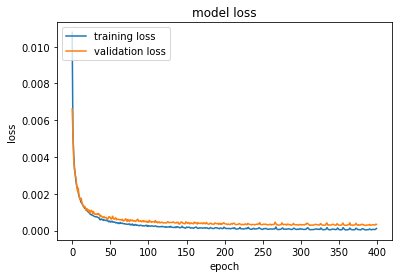

Run Time: 63.0 min


In [4]:
for step in range(18,19):
    
    Dataset1 = np.concatenate([np.array(Dataset_SOn)[:,0:39], np.array(Dataset_SOn)[:,(39+step-1):(39+step)]], axis = 1)
    
    ########################################## Splitting the dataset ##############################################
    
    from sklearn.model_selection import train_test_split

    X = Dataset1[:, 0 :39]
    Y = Dataset1[:, 39:40]

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

    Xtrain_CNN = Xtrain.reshape(Xtrain.shape[0], 39, 1)
    Ytrain_CNN = Ytrain
    Xtest_CNN = Xtest.reshape(Xtest.shape[0], 39, 1)
    Ytest_CNN = Ytest

    frac_val = 10                                # Enter the fraction of validation set to take from training set 
    nv = Xtrain.shape[0]//frac_val

    Xval = Xtrain[0:nv,:]
    Yval = Ytrain[0:nv,:]
    Xval_CNN = Xval.reshape(Xval.shape[0], 39, 1)
    Yval_CNN = Yval

    Xtrain_P = Xtrain[nv:Xtrain.shape[0], :]
    Ytrain_P = Ytrain[nv:Ytrain.shape[0], :]
    Xtrain_P_CNN = Xtrain_P.reshape(Xtrain_P.shape[0], 39, 1)
    Ytrain_P_CNN = Ytrain_P
    
    ###################################### Defining the function for CNN #########################################
    
    def CNN(FS1, FS2, FS3, KS, NS1, NS2, Ep, BS, itera): #, partial_xtrain_CNN, partial_ytrain_CNN, xval_CNN, yval_CNN, xtest_CNN, ytest_CNN):
        from tensorflow.keras import Sequential
        from tensorflow.keras.layers import Dense
        from tensorflow.keras.layers import Conv1D
        from tensorflow.keras.layers import Flatten
        from tensorflow.keras.callbacks import EarlyStopping
        from tensorflow.keras.utils import plot_model
        from sklearn.metrics import mean_squared_error
        from sklearn.metrics import r2_score
        import matplotlib.pyplot as plt
        from numpy.random import seed
        #from tensorflow import set_random_seed
        import os
        import tensorflow as tf
    
        from timeit import default_timer as timer
        start = timer()
        #####################################################################################################
        from tensorflow.compat.v1 import ConfigProto, InteractiveSession  #stop the growing RAM for GPU
    
        config = ConfigProto()
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.6
        sess = InteractiveSession(config=config)
        #############################################################################################################
        os.environ['PYTHONHASHSEED']=str(1)
        np.random.seed(1)
        #tf.set_random_seed(1)\
        
        for _ in range(0,itera):
    
            start = timer()

############################################### Model Built Up ######################################################

            model = Sequential()
            model.add(Conv1D(FS1, KS, activation='relu', input_shape=(39,1)))
            model.add(Conv1D(FS2, KS, activation='relu', input_shape=(39,1)))
            model.add(Conv1D(FS3, KS, activation='relu', input_shape=(39,1)))
            model.add(Flatten())
            model.add(Dense(NS1, activation='relu'))
            model.add(Dense(NS2, activation='relu'))
            model.add(Dense(1, activation='linear'))
            model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
            model.summary()
            
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
            history = model.fit(Xtrain_P_CNN, Ytrain_P_CNN, epochs=Ep, batch_size=BS, verbose=0,\
            validation_data=(Xval_CNN, Yval_CNN), callbacks=[es])
            
            model.save('C:/Users/pymnb/Downloads/WAG Case/18/CNN models/CNN_model_SO'+str(step)+'.h5')
            #model.save('C:/Users/pymnb/Downloads/WAG Case/18/CNN models/CNN_model_P'+str(step)+'.h5')
            
            ypred_train = model.predict(Xtrain_P_CNN)
            ypred_test = model.predict(Xtest_CNN)
    
            r2_train = r2_score(Ytrain_P_CNN, ypred_train)
            rmse_train = mean_squared_error(Ytrain_P_CNN, ypred_train)
            
            r2_test = r2_score(Ytest_CNN, ypred_test)
            rmse_test = mean_squared_error(Ytest_CNN, ypred_test)
    
            print( "R2_Training: {0:f}, RMSE_Training : {1:f}".format(r2_train, rmse_train))
            print( "R2_Test: {0:f}, RMSE_Test : {1:f}".format(r2_test, rmse_test))

################################################### plotting #########################################################

            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['training loss', 'validation loss'], loc='upper left')
            plt.show()

            end = timer()
            print("Run Time: "+str((end - start)//60)+" min")
            sess.close()
    ##############################################################################################################3
    
    
    CNN(90,  87,  77,  10,  61,  90,  400, 500, 1)

## MLP model

C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 31)                1240      
_________________________________________________________________
dense_133 (Dense)            (None, 62)                1984      
_________________________________________________________________
dense_134 (Dense)            (None, 1)                 63        
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________
R2_Training: 0.968959, RMSE_Training : 0.001573
R2_Test: 0.963029, RMSE_Test : 0.001820


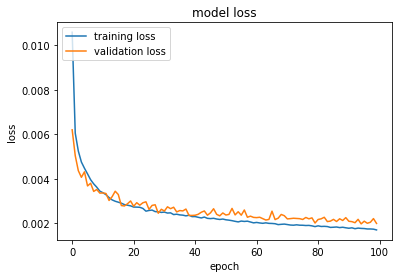

Run Time: 0.0 min


In [121]:
step = 10
Dataset1 = np.concatenate([np.array(Dataset_SOn)[0:70000,0:39], np.array(Dataset_SOn)[0:70000,(39+step-1):(39+step)]], axis = 1)
    
    
########################################## Spitting the dataset ##############################################
    
import pandas as pd
from sklearn.model_selection import train_test_split


X = np.array(Dataset1)[:, 0 :39]
Y = np.array(Dataset1)[:, 39:40]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

frac_val = 10                                # Enter the fraction of validation set to take from training set 
nv = Xtrain.shape[0]//frac_val

Xval = Xtrain[0:nv,:]
Yval = Ytrain[0:nv,:]

Xtrain_P = Xtrain[nv:Xtrain.shape[0], :]
Ytrain_P = Ytrain[nv:Ytrain.shape[0], :]

###################################### Defining the function for CNN ########################################
    
def MLP(NS1, NS2, Ep, BS, itera): #, partial_xtrain_CNN, partial_ytrain_CNN, xval_CNN, yval_CNN, xtest_CNN, ytest_CN
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.utils import plot_model
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    import matplotlib.pyplot as plt
    from numpy.random import seed

    import os
    import tensorflow as tf
    
    from timeit import default_timer as timer
    start = timer()
    #####################################################################################################
    from tensorflow.compat.v1 import ConfigProto, InteractiveSession  #stop the growing RAM for GPU
    
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.6
    sess = InteractiveSession(config=config)
    #############################################################################################################
    os.environ['PYTHONHASHSEED']=str(1)
    np.random.seed(1)
        
    for _ in range(0,itera):
    
        start = timer()

############################################### Model Built Up ######################################################

        model = Sequential()
        model.add(Dense(NS1, activation='relu', input_shape = (39, )))
        model.add(Dense(NS2, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
        model.summary()
            
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
        history = model.fit(Xtrain_P, Ytrain_P, epochs=Ep, batch_size=BS, verbose=0,\
        validation_data=(Xval, Yval), callbacks=[es])
            
        #model.save('/workspace/myfiles/saves/SO/model_SO'+str(step)+'.h5')
        #model.save('/workspace/myfiles/saves/P/model_P'+str(step)+'.h5')
            
        ypred_train = model.predict(Xtrain_P)
        ypred_test = model.predict(Xtest)
    
        r2_train = r2_score(Ytrain_P, ypred_train)
        rmse_train = mean_squared_error(Ytrain_P, ypred_train)
            
        r2_test = r2_score(Ytest, ypred_test)
        rmse_test = mean_squared_error(Ytest, ypred_test)
    
        print( "R2_Training: {0:f}, RMSE_Training : {1:f}".format(r2_train, rmse_train))
        print( "R2_Test: {0:f}, RMSE_Test : {1:f}".format(r2_test, rmse_test))

################################################### plotting #########################################################

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['training loss', 'validation loss'], loc='upper left')
        plt.show()

        end = timer()
        print("Run Time: "+str((end - start)//60)+" min")
        sess.close()
##############################################################################################################3
    
    
MLP(31,  62, 100, 100, 1)

## Linear Model

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 1)                 40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
R2_Training: 0.796193, RMSE_Training : 0.010196
R2_Test: 0.796723, RMSE_Test : 0.010438


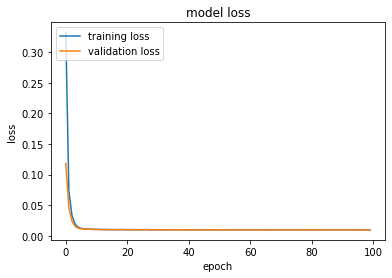

In [119]:
#from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from numpy.random import seed

import os
import tensorflow as tf

step = 10
Dataset1 = np.concatenate([np.array(Dataset_SOn)[0:70000,0:39], np.array(Dataset_SOn)[0:70000,(39+step-1):(39+step)]], axis = 1)

X = np.array(Dataset1)[:, 0 :39]
Y = np.array(Dataset1)[:, 39:40]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

frac_val = 10                                # Enter the fraction of validation set to take from training set 
nv = Xtrain.shape[0]//frac_val

Xval = Xtrain[0:nv,:]
Yval = Ytrain[0:nv,:]

Xtrain_P = Xtrain[nv:Xtrain.shape[0], :]
Ytrain_P = Ytrain[nv:Ytrain.shape[0], :]

model = Sequential([Dense(1, input_shape = (39, ), activation = None )])
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()
#hst = model.fit(XX, YY, batch_size=100, epochs=10, validation_data=(XX_val, yval) )
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
history = model.fit(Xtrain_P, Ytrain_P, epochs=100, batch_size=100, verbose=0,\
        validation_data=(Xval, Yval), callbacks=[es])

#model.save('/workspace/myfiles/saves/SO/model_SO'+str(step)+'.h5')
#model.save('/workspace/myfiles/saves/P/model_P'+str(step)+'.h5')
            
ypred_train = model.predict(Xtrain_P)
ypred_test = model.predict(Xtest)
    
r2_train = r2_score(Ytrain_P, ypred_train)
rmse_train = mean_squared_error(Ytrain_P, ypred_train)
            
r2_test = r2_score(Ytest, ypred_test)
rmse_test = mean_squared_error(Ytest, ypred_test)
    
print( "R2_Training: {0:f}, RMSE_Training : {1:f}".format(r2_train, rmse_train))
print( "R2_Test: {0:f}, RMSE_Test : {1:f}".format(r2_test, rmse_test))

################################################### plotting #########################################################

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

## Test the accuracy of the built model with random LHS points

In [122]:
import numpy as np
import pandas as pd

#x = np.random.randint(low=0, high=5000, size=5).reshape(1,5)

#x = np.array([[3614, 3389, 1528, 1873, 4532]])
#x = np.array([[1873, 3389, 3614, 4532, 1528]])   # for blind test 1

#x = np.array([[308, 2605, 4782,  4399, 4149]])
#x = np.array([[4399, 2605, 308, 4149, 4782]])    # for blindtest 2
 
#x = np.array([[3720, 273,  4777, 1937, 2257]])
#x = np.array([[1937, 273,  3720, 2257, 4777]])   # for blindtest 3

#x = np.array([[2719, 2845, 4478, 3971, 1846]])
x = np.array([[3971, 2845, 2719, 1846, 4478]])   # for blindtest 4

#x = np.array([[4965, 568,  779, 4472, 4494 ]])
#x = np.array([[4472, 568,  4965, 4494, 779 ]])    # for blindtest 5

n_models = 20
Layer = 1    # Enter the Layer number desired to get output

In [11]:
# defining a function to get the text file and expand it

def split(a):
    import numpy as np
    b = a.readlines()
    c = [x.replace('\n','') for x in b]
    d = [j for i in c for j in i.split()]
    e=[]
    for i in d:
        if "*" in i:
            a=[i.split("*")[1]]*int(i.split("*")[0])
            e.extend(a)
        else:
            e.append(i)
    f = np.array(e)
    g = [float(numeric_string) for numeric_string in f]
    h = np.array(g)
    return h

In [12]:
from tensorflow.keras.models import load_model

Dataset_SO_norm = np.loadtxt('/workspace/myfiles/10/10Dataset_SO_Seg')
Dataset_P_norm  = np.loadtxt('/workspace/myfiles/10/10Dataset_P_Seg')
Min_Max_SO = np.loadtxt('/workspace/myfiles/10/10Min_Max_SO')
Min_Max_P = np.loadtxt('/workspace/myfiles/10/10Min_Max_P')
actives = np.loadtxt('/workspace/myfiles/10/active_cells_index')
actives = actives.astype(np.int64)

X = np.repeat(x, 61416, axis=0)
X = (X-0)/(5000-0)

inputs_SO = np.concatenate([Dataset_SO_norm, X], axis = 1)
inputs_P  = np.concatenate([Dataset_P_norm, X], axis = 1)

m1 = load_model('/workspace/myfiles/saves/SO/testmodel1.h5')

In [13]:
r_PF11B = split(open('//workspace//myfiles//Regions//reg11B.txt','r')).reshape((680400,5),order='F')
r_PF12  = split(open('//workspace//myfiles//Regions//reg12.txt','r')).reshape((680400,5),order='F')
r_PF14  = split(open('//workspace//myfiles//Regions//reg14.txt','r')).reshape((680400,5),order='F')
r_PF1C  = split(open('//workspace//myfiles//Regions//reg1C.txt','r')).reshape((680400,5),order='F')
r_PF15C = split(open('//workspace//myfiles//Regions//reg15C.txt','r')).reshape((680400,5),order='F')
r_IF5   = split(open('//workspace//myfiles//Regions//regIF5.txt','r')).reshape((680400,5),order='F')
r_IF4   = split(open('//workspace//myfiles//Regions//regIF4.txt','r')).reshape((680400,5),order='F')
r_IF1B  = split(open('//workspace//myfiles//Regions//reg1B.txt','r')).reshape((680400,5),order='F')

DatasetG_SO_norm = np.loadtxt('/workspace/myfiles/10/10Dataset_SO_norm')
DatasetG_P_norm  = np.loadtxt('/workspace/myfiles/10/10Dataset_P_norm')

In [14]:
tier = 1      # enter the tier number    1=30 , 2=60, 3=90, 4=120, 5=150

ac_PF11B = r_PF11B[:,tier-1:tier][actives]           # remove the aquifer grids
ac_PF12  = r_PF12[:,tier-1:tier][actives]
ac_PF14  = r_PF14[:,tier-1:tier][actives]
ac_PF1C  = r_PF1C[:,tier-1:tier][actives]
ac_PF15C = r_PF15C[:,tier-1:tier][actives]
ac_IF5   = r_IF5[:,tier-1:tier][actives]
ac_IF4   = r_IF4[:,tier-1:tier][actives]
ac_IF1B  = r_IF1B[:,tier-1:tier][actives]

T_PF11B, T_PF12, T_PF14, T_PF1C, T_PF15C, T_IF5, T_IF4, T_IF1B = np.where(ac_PF11B!=0)[0],\
            np.where(ac_PF12!=0)[0], np.where(ac_PF14!=0)[0], np.where(ac_PF1C!=0)[0], np.where(ac_PF15C!=0)[0],\
            np.where(ac_IF5!=0)[0], np.where(ac_IF4!=0)[0], np.where(ac_IF1B!=0)[0]

LOC = np.unique(np.concatenate((T_PF11B,T_PF12, T_PF14, T_PF1C, T_PF15C, T_IF5, T_IF4, T_IF1B),axis = 0))
Location = LOC.reshape(LOC.shape[0],1)
print(Location.shape)

(826, 1)


In [15]:
ypred_norm_SO = m1.predict(inputs_SO.reshape(inputs_SO.shape[0], 31, 1))
ypred_SO = ypred_norm_SO*(1-0)+0

textfile_SO = open('/workspace/myfiles/SO/extra/SOtest4.txt','r')
y_real_SO = split(textfile_SO).reshape((108*100*63, 41), order='F')[actives][:,2:41:2]

In [16]:
real = y_real_SO[:,0:1]
real1 = real[Location].reshape(real[Location].shape[0],1)
print(real1.shape)
predi = ypred_SO.reshape(ypred_SO.shape[0],1)
predi1 = predi[Location].reshape(predi[Location].shape[0],1)
print(predi1.shape)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


r2_SO = r2_score(real1, predi1)
rmse_SO = mean_squared_error(real1, predi1)
print( "R2: {0:f},   RMSE: {1:f}".format(r2_SO, rmse_SO))

(826, 1)
(826, 1)
R2: 0.977905,   RMSE: 0.000775
